In [30]:
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
import numpy as np
import pandas as pd

import gym

import matplotlib.pyplot as plt
%matplotlib inline

In [31]:
class Agent():
    def __init__(self, env, alpha, beta, epochs=5, epsilon=0.2, entropy_loss=5e-3, gamma=0.99,
                 layer1_size=1024, layer2_size=512):
        self.env = env
        self.n_states = env.observation_space.shape[0]
        self.n_actions = env.action_space.n
        self.alpha = alpha
        self.beta = beta
        self.epochs = epochs
        self.epsilon = epsilon
        self.entropy_loss = entropy_loss
        self.gamma = gamma
        self.layer1_size = layer1_size
        self.layer2_size = layer2_size
    
        self.actor, self.critic, self.policy = self.build_actor_critic_network()
        self.clear_replay_buffer()
        
    def build_actor_critic_network(self):
        inputs = Input(shape=(self.n_states,))
        advantage = Input(shape=[1])
        old_policy = Input(shape=[self.n_actions])
        dense1 = Dense(self.layer1_size, activation='relu')(inputs)
        dense2 = Dense(self.layer2_size, activation='relu')(dense1)
        probs = Dense(self.n_actions, activation='softmax')(dense2)
        values = Dense(1, activation=None)(dense2)
        
        def custom_loss(y_true, y_pred):
            prob = K.sum(y_true * y_pred, axis=1)
            old_prob = K.sum(y_true * old_policy, axis=1)
            r_theta = prob / (old_prob + 1e-10)
            unclip_obj = r_theta * advantage
            clip_obj = K.clip(r_theta, 1 - self.epsilon, 1 + self.epsilon) * advantage
            entropy = self.entropy_loss * -(prob * K.log(prob + 1e-10))
            actor_loss = -K.mean(K.minimum(unclip_obj, clip_obj) + entropy)
            return actor_loss
        
        actor = Model(inputs=[inputs, advantage, old_policy], outputs=[probs])
        actor.compile(optimizer=Adam(lr=self.alpha), loss=custom_loss)
        
        critic = Model(inputs=[inputs], outputs=[values])
        critic.compile(optimizer=Adam(lr=self.beta), loss='mse')
        
        # When we choose an action from the actor we do not need to add an input from the critic (delta)
        # no compile because we arn't doing any back prop on it. Shares weights with actor and critic
        policy = Model(inputs=[inputs], outputs=[probs]) 
        
        return actor, critic, policy
    
    def clear_replay_buffer(self):
        self.actions = []
        self.probs = []
        self.states = []
        self.rewards = []
        self.next_states = [] 
        self.dones = []
        
    def add_to_replay_buffer(self, action, prob, state, reward, next_state, done):
        self.actions.append(action)
        self.probs.append(prob)
        self.states.append(state)
        self.rewards.append(reward)
        self.next_states.append(next_state)   
        self.dones.append(done)
        
    def get_batch_from_replay_buffer(self):
        idx = list(range(len(self.actions)))
        np.random.shuffle(idx)
        actions = np.array(self.actions)[idx]
        probs = np.array(self.probs)[idx]
        states = np.array(self.states)[idx]
        rewards = np.array(self.rewards)[idx]
        next_states = np.array(self.next_states)[idx]
        dones = np.array(self.dones)[idx]
        return actions, probs, states, rewards, next_states, dones
        
    def choose_action(self, observation):
        observation = np.expand_dims(observation, axis=0)
        probs = self.policy.predict(observation).flatten()
        action = np.random.choice(range(self.n_actions), p=probs)
        return action, probs
    
    def learn_from_replay_buffer(self):
        actions, probs, states, rewards, next_states, dones = self.get_batch_from_replay_buffer()

        critic_state_values = self.critic.predict(np.vstack(states)).flatten()
        critic_next_state_values = self.critic.predict(np.vstack(next_states)).flatten()
        
        targets = rewards + self.gamma * critic_next_state_values * (1 - dones)
        advantages = targets - critic_state_values
        
        one_hot_actions = np.zeros((actions.shape[0], self.n_actions))
        one_hot_actions[range(actions.shape[0]), actions] = 1
         
        self.actor.fit([np.vstack(states), np.vstack(advantages), np.vstack(probs)], one_hot_actions,
                       epochs=self.epochs, verbose=0)
        self.critic.fit(np.vstack(states), np.vstack(targets), epochs=self.epochs , verbose=0)    
        self.clear_replay_buffer()

In [133]:
tf.compat.v1.disable_eager_execution()

# env_name = 'CartPole-v0' #DONE
# env_name = 'MountainCar-v0' #DONE
# env_name = 'MountainCarContinuous-v0'
# env_name = 'Acrobot-v1' # DONE
# env_name = 'Pendulum-v0' #DONE
env_name = 'LunarLander-v2' #Done
env = gym.make(env_name)

agent = Agent(env=env, alpha=1e-4, beta=9e-4, epochs=5, epsilon=0.2, entropy_loss=0, gamma=0.99,
                 layer1_size=1024, layer2_size=512)

In [ ]:
highscores = [0]
ep = 0
it = 0

#n_games = 1000
# for ep in range(n_games):
while np.mean(highscores[-100:]) <= 280:
    done = False
    score = 0
    observation = env.reset()
    
    while not done:
        it += 1
        action, prob = agent.choose_action(observation)
        next_observation, reward, done, info = env.step(action)
        #reward += (abs(next_observation[0]) + 0.3)**2 / 100 # Mountain car exploration
        agent.add_to_replay_buffer(action, prob, observation, reward, next_observation, done)
        observation = next_observation
        score += reward

        if it == 128:
            agent.learn_from_replay_buffer() 
            it = 0
        
    highscores.append(score)
    avg_score = np.mean(highscores[-100:])
    print(f'episode: {ep} score: {round(score, 2)} average_score: {round(avg_score)}', end="\r", flush=False, file=open('result.txt','a+'))
    print(f'episode: {ep} score: {round(score, 2)} average_score: {round(avg_score)}', end="\r", flush=False)
    ep += 1

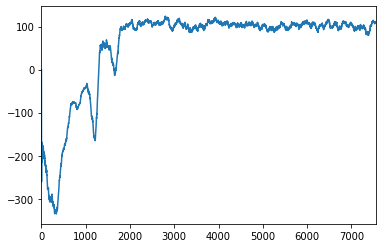

In [132]:
pd.Series(highscores).rolling(min_periods=1, window=100).mean().plot()

In [6]:
test_highscores = []

for i in range(5):
    done = False
    score = 0
    observation = env.reset()
    
    while not done:
        env.render()
        action, prob = agent.choose_action(observation)
        next_observation, reward, done, info = env.step(action)
        observation = next_observation
        score += reward
        
    test_highscores.append(score)
    
env.close()
test_highscores, np.mean(test_highscores)

([251.06579009678725,
  292.2316464021079,
  -45.19972830457547,
  242.6901921898479,
  277.8522722516825],
 203.72803452717002)